In [ ]:
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

import os
print(os.getcwd())

/content


In [ ]:
if "food-101" in os.listdir():
    print("Dataset already exists")
else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz > /dev/null 2>&1
    print("Extraction done!")

--2024-06-18 06:47:33--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-06-18 06:47:33--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  26.2MB/s    in 3m 7s   

2024-06-18 06:50:40 (25.5 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

Dataset downloaded!
Extracting data..
Extraction done!


In [ ]:
classes = open("./food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'other'],
 21)

In [ ]:
!echo "Testing images"
!head -n 5 ./food-101/meta/test.txt
!echo -e "\nTraining images"
!head -n 5 ./food-101/meta/train.txt | head -n 5

Testing images
apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694

Training images
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283


In [ ]:
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    # Getting the full path for the images
    img_path = "./food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]

    # Splitting the image index from the label
    imgs = []
    for img in array:
        img = img.split('/')

        imgs.append(img)

    imgs = np.array(imgs)
    # Converting the array to a data frame
    imgs = pd.DataFrame(imgs[:,0], imgs[:,1], columns=['label'])
    # Adding the full path to the data frame
    imgs['path'] = full_path

    # Randomly shuffling the order to the data in the dataframe
    imgs = shuffle(imgs)

    return imgs
train_imgs = prep_df('./food-101/meta/train.txt')
test_imgs = prep_df('./food-101/meta/test.txt')

train_imgs.head(5)

,label,path
2769214,macaroni_and_cheese,./food-101/images/macaroni_and_cheese/2769214.jpg
716644,tiramisu,./food-101/images/tiramisu/716644.jpg
350358,pizza,./food-101/images/pizza/350358.jpg
3905030,hot_dog,./food-101/images/hot_dog/3905030.jpg
2269307,grilled_cheese_sandwich,./food-101/images/grilled_cheese_sandwich/2269...


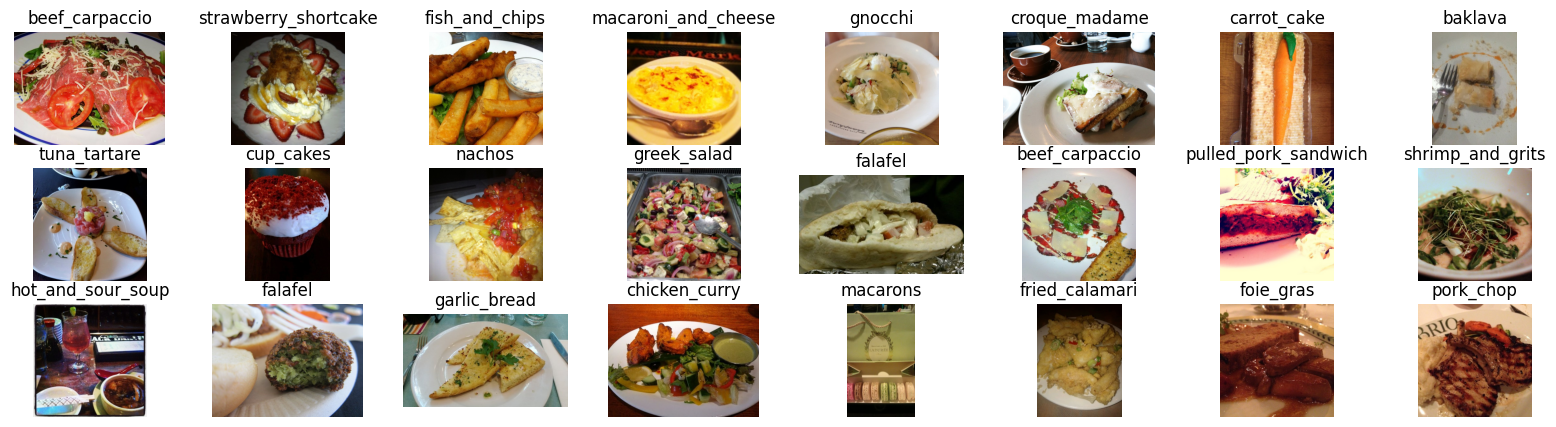

In [ ]:
plt.figure(figsize=(20, 5))

num_rows = 3
num_cols = 8


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

In [ ]:
# Data augmentation for training
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# Data augmentation for testing
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
class Label_encoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(classes)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = Label_encoder(classes)
for i in range(20):
    print(encoder.get_label(i), encoder.get_idx( encoder.get_label(i) ))

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19


In [ ]:
class Food20(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label
train_dataset = Food20(train_imgs, transform=train_transforms)
test_dataset = Food20(test_imgs, transform=test_transforms)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
# Testing the retrieval of a single image
for i in range(10):
    image = train_dataset.__getitem__(i)
    print(encoder.get_label(image[1]), image[0].shape)

macaroni_and_cheese torch.Size([3, 224, 224])
tiramisu torch.Size([3, 224, 224])
pizza torch.Size([3, 224, 224])
hot_dog torch.Size([3, 224, 224])
grilled_cheese_sandwich torch.Size([3, 224, 224])
shrimp_and_grits torch.Size([3, 224, 224])
croque_madame torch.Size([3, 224, 224])
garlic_bread torch.Size([3, 224, 224])
omelette torch.Size([3, 224, 224])
red_velvet_cake torch.Size([3, 224, 224])


In [ ]:
import requests as reqs
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained DenseNet201 weights from ImageNet
weights = models.DenseNet201_Weights.IMAGENET1K_V1
model = models.densenet201(weights=weights)

# Freeze parameters of the pretrained model to prevent backpropagation
for param in model.parameters():
    param.requires_grad = False

# Define the URL of the custom classifier weights
url = "https://github.com/Prakhar998/Food-Classification/raw/master/food_classifier.pt"

# Download the custom classifier weights
response = reqs.get(url, allow_redirects=True)
with open("./food_classifier.pt", "wb") as file:
    file.write(response.content)

# Define the custom classifier architecture
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 101)
)

# Replace the default classifier with the custom classifier
model.classifier = classifier

# Load the custom weights into the model
checkpoint_path = "./food_classifier.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'), strict=False)

# Move the model to the specified device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu